In [1]:
import os
import datetime
import dateutil
import pandas as pd
import requests
import matplotlib
import matplotlib.pyplot as plt

Functions

In [2]:
def moving_avg(df, freq):
    ma_df = df.copy()
    ma_df = ma_df.set_index([cols.freq,cols.date])
    ma_df = ma_df.groupby([cols.country])[[i for i in ma_df.columns.tolist() if i!=cols.country]].rolling(freq).mean()
    ma_df = ma_df.reset_index()
    ma_df[cols.freq] = f'{freq}-day Moving Average'

    # remove jagged edges: drop empty up to first valid index, drop empty after last valid index
    ma_df = pd.melt(ma_df, id_vars=cols.base)
    ma_df = ma_df[(ma_df.groupby([i for i in ma_df if i not in [cols.date,'value']])['value'].bfill().notnull())&
                  (ma_df.groupby([i for i in ma_df if i not in [cols.date,'value']])['value'].ffill().notnull())]
    ma_df = pd.pivot_table(ma_df,index=cols.base,columns=['variable'],values='value')
    ma_df = ma_df.reset_index()

    ma_df = ma_df[df.columns.tolist()]
    return(ma_df)

In [3]:
def get_pop(cty):
    url_root = 'https://restcountries.com/v3.1/name/'
    url_suffix = '?fields=population'

    response = requests.get(url_root + ''.join(cty.lower().split()) + url_suffix)
    json_data = response.json()
    return(json_data[0]['population'])

In [4]:
# merge populations into cases df to find number of cases per million people
def merge_pop(df, pop_dict):
    pop_df = pd.DataFrame(pop_dict.items(), columns=[cols.country, cols.pop])
    pop_df[cols.pop] = pop_df[cols.pop] / 10**6

    merged_df = df.merge(pop_df, how='left')

    for i in cols.data:
        merged_df[f'{i} per Million Population'] = merged_df[i] / merged_df[cols.pop]

    return(merged_df)

In [5]:
def plot_chart(df, country_list, freq, no_months=12, export=False):

    meta = {'x-axis':cols.date,
            'y-axis':f'{cols.cases_new} per Million Population',
            'fontsize':8,
            cols.freq:freq,
            'date from':(datetime.datetime.now() - dateutil.relativedelta.relativedelta(months=no_months)).date()}
    meta['title'] = f'{meta["y-axis"]} ({freq})'

    plt.rcParams.update({'font.size':meta['fontsize']}) # default font size

    fig, ax = plt.subplots(figsize=(8,4))

    # df by frequency and date range. will use loop to plot each country series.
    plot_df = df.loc[(df[cols.freq]==meta[cols.freq])&
                     (df[cols.date]>=meta['date from'])]

    for cty in country_list:
        ax.plot(plot_df.loc[(plot_df[cols.country]==cty)][meta['x-axis']],
                plot_df.loc[(plot_df[cols.country]==cty)][meta['y-axis']], label=cty)

    # chart title, legend, axis names, rotate x-axis labels
    ax.set_title(meta['title'],fontweight='bold')
    ax.legend(loc='upper left')
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

    # x-axis: space out axis for subplot and set tick frequency
    ax.set_xlim(plot_df[cols.date].min(), plot_df[cols.date].max())
    ax.xaxis.set_ticks(pd.date_range(plot_df[cols.date].min(), plot_df[cols.date].max(), freq='w'))

    # y-axis: min limit is 0, number format include comma
    ax.set_ylim(bottom=0)
    ax.yaxis.set_ticks(ax.get_yticks().tolist())
    ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

    # spines and ticks
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')

    plt.tight_layout()
    plt.show()

    if export:
        fig.savefig(f'{meta["title"]}.jpg', bbox_inches='tight', format='jpg', dpi=360)

Static data 

In [6]:
countries = ['Indonesia','Malaysia','Philippines','Singapore','Thailand','Viet Nam']

In [7]:
class Cols:
    def __init__(self):
        self.freq = 'Frequency'
        self.date = 'Date Reported'
        self.country = 'Country'
        self.pop = 'Population (Million)'
        self.cases_new = 'New Cases'
        self.cases_all = 'Cumulative Cases'
        self.deaths_new = 'New Deaths'
        self.deaths_all = 'Cumulative Deaths'

        self.base = [self.country, self.freq, self.date]
        self.data = [self.cases_new, self.deaths_new, self.cases_all, self.deaths_all]

        self.rename = {'Date_reported':self.date,
                       'New_cases':self.cases_new, 'New_deaths':self.deaths_new,
                       'Cumulative_cases':self.cases_all, 'Cumulative_deaths':self.deaths_all}

cols = Cols()

COVID cases data

In [8]:
# WHO COVID-19 cases
covid_url = 'https://covid19.who.int/'
covid_file = covid_url + 'WHO-COVID-19-global-data.csv'
covid_df = pd.read_csv(covid_file, encoding='utf-8')

In [9]:
# keep only selected columns and countries and clean df
countries_df = covid_df[[cols.country] + list(cols.rename.keys())]
countries_df = countries_df[countries_df[cols.country].isin(countries)].reset_index(drop=True)
countries_df = countries_df.rename(columns=cols.rename)

# date format as pd.datetime
countries_df[cols.date] = pd.to_datetime(countries_df[cols.date]).dt.date

# add moving average
days = 7
countries_df[cols.freq] = 'Actual'
countries_df = countries_df[cols.base+cols.data]
countries_df = pd.concat([countries_df, moving_avg(countries_df, days)]).reset_index(drop=True)

Country population data (https://restcountries.com)

In [10]:
pop = {}
for cty in countries:
    pop[cty] = get_pop(cty)

In [11]:
countries_df_pop = merge_pop(countries_df, pop)

Plot charts 

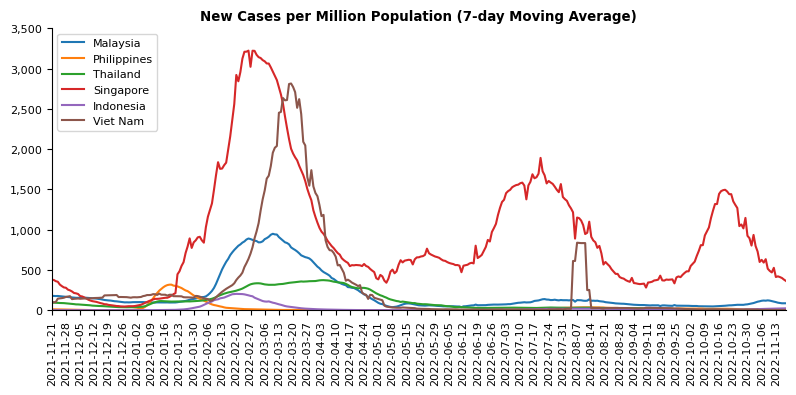

In [12]:
plot_chart(df=countries_df_pop,
           country_list=set(countries_df_pop[cols.country]),
           freq=f'{days}-day Moving Average',
           no_months=12,
           export=False)

Export dataframes

In [13]:
countries_df_pop.to_csv('COVID Cases by Country.csv', index=False)